In [27]:
#import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
#import needed csvs
df_plays = pd.read_csv('plays.csv')
df_player_play_motion = pd.read_csv('player_play_motion_labels.csv')

In [31]:
df_player_play_motion.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,end_rel_y_dis,overall_y_change,init_rel_x_dis,end_rel_x_dis,overall_x_change,motion_s_avg,frames_in_motion,y_reverse_loc,y_flipped,motion_label
0,2022090800,56,42489,BUF,0,0,0,0,0,1,...,-1396,1569,-182,-107,-75,337.021739,46,-1397.0,0,11
1,2022090800,80,47857,BUF,0,0,0,0,0,0,...,201,782,-244,-649,405,346.214286,42,984.0,1,14
2,2022090800,101,53079,BUF,0,0,0,0,0,0,...,-320,322,-475,-256,-219,234.441176,34,-532.0,1,1
3,2022090800,191,53079,BUF,0,0,0,0,0,0,...,613,-59,-221,-146,-75,142.200000,5,614.0,1,12
4,2022090800,212,47879,BUF,0,0,0,0,0,0,...,-344,900,-195,-275,80,412.727273,22,-344.0,0,15


In [33]:
#careful to account for the flipped y

# Create the initial condition for movement classification
positive_condition = (df_player_play_motion['init_rel_y_dis'] > 0) & (df_player_play_motion['end_rel_y_dis'] > 0)

# Assign 1 where both values are positive, otherwise 2
df_player_play_motion['flipped_side'] = positive_condition.astype(int) + 1

# Make values negative where 'y_flipped' is 1
df_player_play_motion['flipped_side'] *= np.where(df_player_play_motion['y_flipped'] == 1, -1, 1)

#1: stayed on left
#2: went left to right
#3: stayed on right
#4: went right to left

In [35]:
df_motion_labels = df_player_play_motion[['gameId','playId','nflId','motion_label','flipped_side']]

In [37]:
#get all motions on each play (note: max is 5 motions on a play)
#df_motion_labels_combined = df_motion_labels.groupby(['gameId', 'playId'], as_index=False).agg(lambda x: list(x))

In [39]:
df_plays_labeled = df_plays.merge(df_motion_labels,on=['gameId','playId'],how='left')
df_plays_labeled['motion_label'] = df_plays_labeled['motion_label'].fillna(-1)

In [41]:
df_plays_labeled['is_rush'] = np.where(df_plays_labeled['passResult'].isna(), 1, 0)

In [43]:
# Assuming df_motion_labels_combined is your DataFrame
motion_dfs_dict = {label: group for label, group in df_plays_labeled.groupby('motion_label')}

In [45]:
# # Check the data type of the motion_label column
# print(df_motion_labels_combined['motion_label'].dtype)

# # If it's not a string type, convert it to string
# df_motion_labels_combined['motion_label'] = df_motion_labels_combined['motion_label'].astype(str)

# # Now group by motion_label and create a dictionary of DataFrames
# df_plays_labeled = {label: group for label, group in df_motion_labels_combined.groupby('motion_label')}

In [47]:
#EPA for every category
for i in df_plays_labeled['motion_label'].unique(): 
    mean_value = motion_dfs_dict[i]['expectedPointsAdded'].mean() 
    count_value = len(motion_dfs_dict[i]['expectedPointsAdded'])
    print(f"{i:<6} Mean: {mean_value:<8.3f} Count: {count_value:<6}")

-1.0   Mean: -0.074   Count: 11304 
3.0    Mean: 0.168    Count: 616   
12.0   Mean: 0.013    Count: 528   
1.0    Mean: 0.164    Count: 275   
8.0    Mean: -0.068   Count: 208   
6.0    Mean: 0.007    Count: 285   
10.0   Mean: 0.130    Count: 176   
5.0    Mean: -0.011   Count: 584   
9.0    Mean: 0.045    Count: 394   
15.0   Mean: 0.078    Count: 567   
4.0    Mean: 0.112    Count: 225   
0.0    Mean: 0.157    Count: 82    
13.0   Mean: 0.107    Count: 193   
2.0    Mean: 0.191    Count: 550   
11.0   Mean: 0.080    Count: 305   
16.0   Mean: 0.171    Count: 298   
7.0    Mean: 0.152    Count: 177   
14.0   Mean: -0.042   Count: 166   
17.0   Mean: -0.413   Count: 2     


In [49]:
motion_dfs_dict[0].head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,nflId,motion_label,flipped_side,is_rush
78,2022101600,1215,(7:13) (Shotgun) J.Garoppolo pass short right ...,2,2,9,SF,ATL,ATL,14,...,True,NaN,NaN,0,Cover-1,Man,46377.0,0.0,1.0,0
176,2022091109,3568,(10:18) (Shotgun) C.Wentz pass short left to L...,4,3,8,WAS,JAX,WAS,24,...,True,NaN,NaN,0,Cover-3,Zone,43722.0,0.0,-1.0,0
257,2022091113,1812,(:29) (Shotgun) T.Brady pass incomplete short ...,2,2,10,TB,DAL,DAL,29,...,True,NaN,NaN,0,Cover-1,Man,44816.0,0.0,-1.0,0
294,2022091806,1189,(10:02) (Shotgun) M.Trubisky pass incomplete s...,2,1,15,PIT,NE,NE,24,...,True,NaN,NaN,0,Quarters,Zone,54905.0,0.0,1.0,0
326,2022101603,200,(13:23) (Shotgun) M.Ryan pass short left to M....,1,1,20,IND,JAX,IND,35,...,True,NaN,NaN,0,Cover-2,Zone,53703.0,0.0,1.0,0


In [53]:
#find what percentage of plays with each motion were run plays / pass plays

#overall
overall_rush_pct = df_plays_labeled['is_rush'].mean()
overall_count = len(df_plays_labeled['is_rush'])
print(f"overall{'':<4}: {overall_rush_pct:<8.2%} num: {overall_count:<6}")

#per motion
for i in df_plays_labeled['motion_label'].unique():
    motion_rush_pct = motion_dfs_dict[i]['is_rush'].mean()
    motion_count = len(motion_dfs_dict[i]['is_rush'])
    print(f"motion {i:<4}: {motion_rush_pct:<8.2%} num: {motion_count:<6}")

#go further, compare game situation/formation

overall    : 38.84%   num: 16935 
motion -1.0: 45.61%   num: 11304 
motion 3.0 : 46.59%   num: 616   
motion 12.0: 28.22%   num: 528   
motion 1.0 : 25.09%   num: 275   
motion 8.0 : 29.33%   num: 208   
motion 6.0 : 12.98%   num: 285   
motion 10.0: 26.14%   num: 176   
motion 5.0 : 33.39%   num: 584   
motion 9.0 : 21.32%   num: 394   
motion 15.0: 27.51%   num: 567   
motion 4.0 : 9.78%    num: 225   
motion 0.0 : 6.10%    num: 82    
motion 13.0: 40.93%   num: 193   
motion 2.0 : 12.73%   num: 550   
motion 11.0: 12.13%   num: 305   
motion 16.0: 18.12%   num: 298   
motion 7.0 : 7.91%    num: 177   
motion 14.0: 33.73%   num: 166   
motion 17.0: 0.00%    num: 2     


In [364]:
#Idea: check whether the motion direction is an accurate indicator of which direction a run goes in
#can also look at it factoring in total bodies on each side of the line

#useful columns: 'rushLocationType', 'pff_runConceptPrimary', 'pff_runConceptSecondary'

In [366]:
df_plays_rush = df_plays_labeled[df_plays_labeled['passResult'].isna()]

In [368]:
#filter out unknown rush areas
df_plays_rush = df_plays_rush[df_plays_rush['rushLocationType'] != 'UNKNOWN']

In [370]:
df_player_play_motion.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,min_y_rel_pos,y_flipped,dis_line_start,dis_line_end,max_dist_fb,min_dist_fb,passed_fb,position,motion_label,flipped_side
0,2022090800,80,47857,BUF,0,0,0,0,0,0,...,1069,1,668,-114,84,-988,0,RB,30,-2
1,2022090800,101,53079,BUF,0,0,0,0,0,0,...,542,1,-325,-647,533,-3,0,FB,8,-1
2,2022090800,236,52536,BUF,0,0,0,0,0,1,...,481,1,945,445,-582,-1082,1,WR,1,-2
3,2022090800,299,43399,LA,0,0,0,0,0,0,...,0,0,-324,-805,12,-483,0,TE,10,1
4,2022090800,299,44881,LA,0,0,0,0,0,0,...,621,1,746,123,-419,-1042,1,WR,1,-2


In [372]:
df_rush_loc = df_plays_rush[['flipped_side','rushLocationType']]

In [378]:
df_rush_loc['flipped_side'] = df_rush_loc['flipped_side'].fillna(0)

C:\Users\etien\AppData\Local\Temp\ipykernel_18436\1465710728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rush_loc['flipped_side'] = df_rush_loc['flipped_side'].fillna(0)


In [380]:
df_rush_loc.head()

,flipped_side,rushLocationType
4,0.0,INSIDE_LEFT
5,0.0,INSIDE_RIGHT
6,0.0,OUTSIDE_LEFT
11,2.0,INSIDE_LEFT
15,0.0,OUTSIDE_LEFT


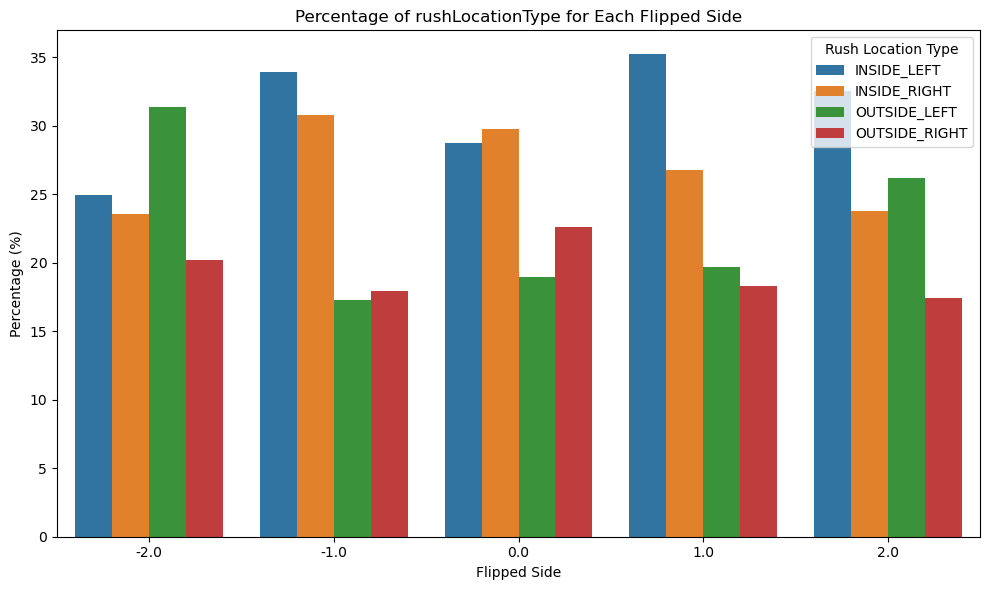

In [382]:
percentage_df = df_rush_loc.groupby(['flipped_side', 'rushLocationType']).size().reset_index(name='count')
percentage_df['percentage'] = percentage_df.groupby('flipped_side')['count'].transform(lambda x: x / x.sum() * 100)

# Create a bar plot for visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=percentage_df, x='flipped_side', y='percentage', hue='rushLocationType')
plt.title('Percentage of rushLocationType for Each Flipped Side')
plt.xlabel('Flipped Side')
plt.ylabel('Percentage (%)')
plt.legend(title='Rush Location Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

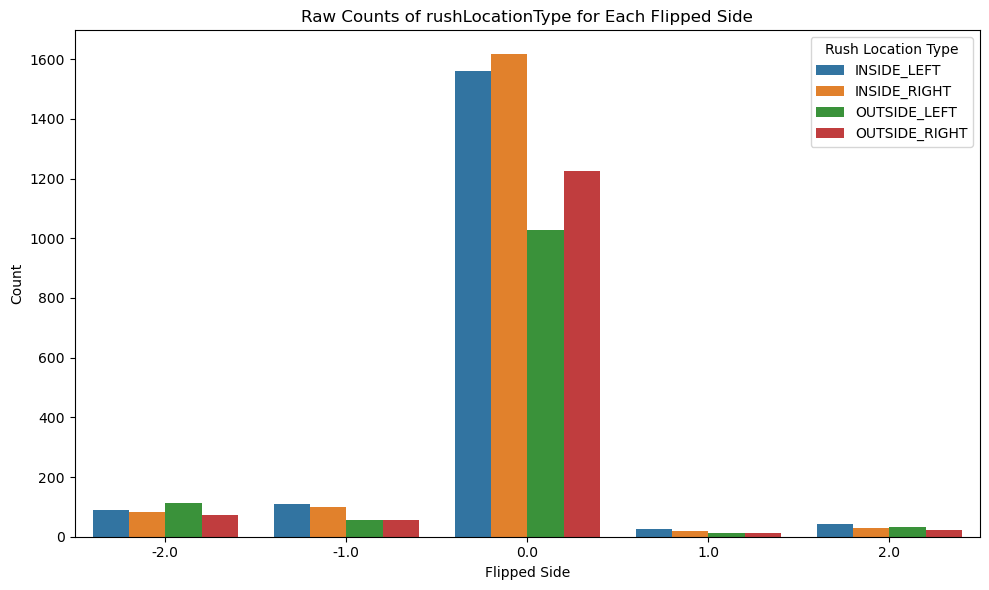

In [384]:
count_df = df_rush_loc.groupby(['flipped_side', 'rushLocationType']).size().reset_index(name='count')

# Create a bar plot for visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=count_df, x='flipped_side', y='count', hue='rushLocationType')
plt.title('Raw Counts of rushLocationType for Each Flipped Side')
plt.xlabel('Flipped Side')
plt.ylabel('Count')
plt.legend(title='Rush Location Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()